# How to define compute magnetic flux with FEMM

This tutorial shows the how to compute magnetic flux and torque with FEMM.  
 
The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Simulation_FEMM.ipynb).


This tutorial is divided into four parts: 
- machine import
- winding definition
- magnetic simulation definition and running
- plot of the magnetic flux for the first time step

### Loading Machine

Before defining the simulation, one first has to define the machine. One could [create a new Machine](tuto_Machine.html), but for this tutorial, we simply import it from a script.

<IPython.core.display.Javascript object>


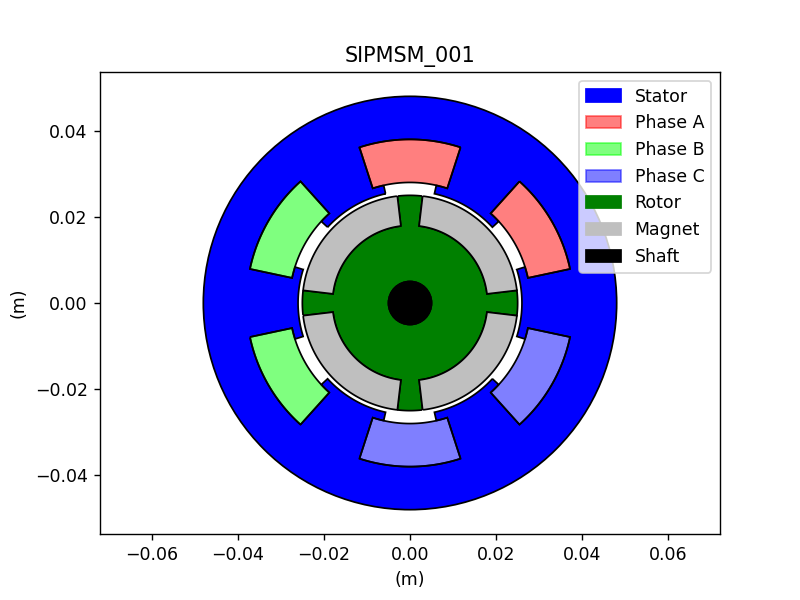

In [1]:
# Add pyleecan to the Python path
import sys
sys.path.append('../..')

# Import the machine from a script
from pyleecan.Tests.Validation.Machine.SIPMSM_001 import SIPMSM_001
%matplotlib notebook
im=SIPMSM_001.plot()

## Simulation definition
### Input currents

To define the simulation, we use [Simu1](http://www.pyleecan.com/pyleecan.Classes.Simu1.html) and [InCurrent](http://www.pyleecan.com/pyleecan.Classes.InCurrent.html) to define the input such as stator currents, the angular and the time discretization. 

In [2]:
from numpy import ones, pi, array
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InCurrent import InCurrent
from pyleecan.Classes.ImportGenVectLin import ImportGenVectLin
from pyleecan.Classes.ImportMatrixVal import ImportMatrixVal

# Create the Simulation
simu = Simu1(name="EM_SIPMSM_AL_001", machine=SIPMSM_001)   

# Add input
time = ImportGenVectLin(start=0, stop=0.1, num=2, endpoint=True) # Electrical time vector without symmetry [s]

# angular steps along the airgap circonference for flux density calculation
angle = ImportGenVectLin(start=0, stop=2 * pi, num=1024, endpoint=False) 
    
Nr = ImportMatrixVal(value=ones(2) * 300) # Rotor speed as a function of time [rpm]

Is = ImportMatrixVal(  # Stator currents as a function of time, each column correspond to one phase [A]
    value=array([[14.1421, -7.0711, -7.0711], [-14.1421, 7.0711, 7.0711]])
)



angle_rotor = ImportMatrixVal(value=array([2.5219, 0.9511]) + pi / 6) # Rotor angular position as a function of time

simu.input = InCurrent(
    Is=Is, 
    Ir=None,  # No winding on the rotor
    Nr=Nr,
    angle_rotor=angle_rotor, # if None computed according to Nr
    time=time,
    angle=angle,
    angle_rotor_initial=0, # initial position of the rotor
)

To call FEMM, we need to define the magnetic part of the simulation with [MagFEMM](http://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) class. As the simulation will only consider magnetic problem, we set the structural part as None to avoid computation.


In [3]:
from pyleecan.Classes.MagFEMM import MagFEMM
# Definition of the magnetic simulation (is_mmfr=False => no flux from the magnets)
simu.mag = MagFEMM(
    is_stator_linear_BH=2, # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    is_rotor_linear_BH=2,  # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    is_symmetry_a=False,   # 0 Compute on the complete machine, 1 compute according to sym_a and is_antiper_a
    is_mmfr=False,         # 1 to compute the rotor magnetomotive force / rotor magnetic field
    angle_stator=-pi / 6,  # Angular position shift of the stator
)
simu.struct = None # We only use the magnetic part 

You can find all the parameters of _MagFEMM_ by looking at [Magnetics](http://www.pyleecan.org/pyleecan.Classes.Magnetics.html) and [MagFEMM](http://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) classes.

### Run simulation
To run the simulation, we first have to set the Output to store the results.

In [4]:
from pyleecan.Classes.Output import Output
out = Output(simu=simu)
simu.run()

Once it is done, the results are stored in the magnetic part of the output (i.e. _out.mag_ ) and one can call different plots : 

<IPython.core.display.Javascript object>


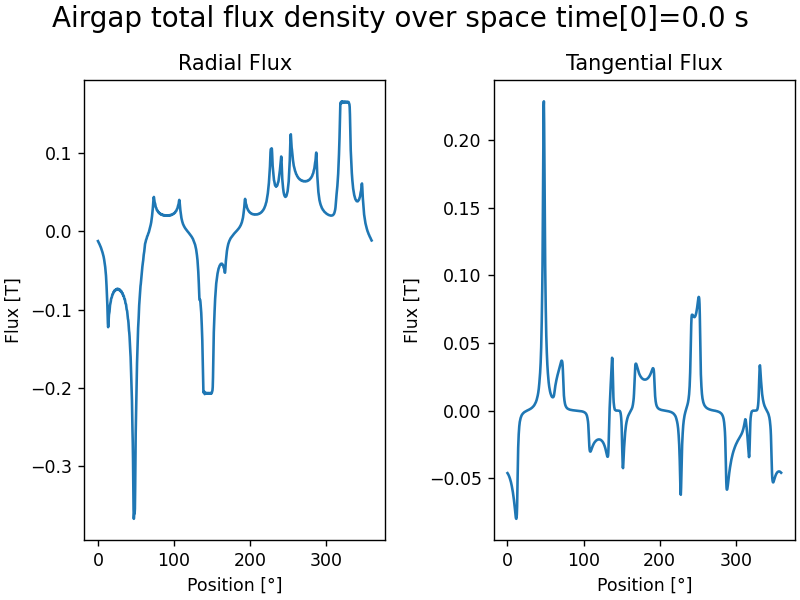

In [5]:
%matplotlib notebook
out.plot_B_space()